In [33]:
!pip install pynrrd
!pip install tensorflow-addons
!python -m pip install typing-extensions --upgrade

In [1]:
import glob
import nrrd
import random
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt


'''
Article about augmentation of US images: https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets
'''


class UltraSoundImages(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, raw_images_paths, raw_masks_paths, augment=True, random_crop=False, size=None):
        self.MAX_SHARPNESS_LEVEL = 5
        self.MIN_CONTRAST_ADJUSTMENT = 0
        self.MAX_CONTRAST_ADJUSTMENT = 2.5
        self.MAX_NOISE_SCALE = 4
        self.ROTATION_RANGE = 15
        
        self.random_crop = random_crop
        self.size = size
        self.batch_size = batch_size
        self.augment = augment
        self.images = []
        self.masks = []

        self.miscellaneous_process = [
            self.sharpen,
            self.adjust_contrast,
            self.adjust_brightness,
            self.add_noise,
            self.gaussian_filter,
        ]
        
        # Image and mask have to be stacked
        self.geometric_process = [
            # self.zoom,
            # self.flip,
            # self.rotate, 
            # self.shear,
            # self.random_crop,
        ]
        
        
        print('Loading images from NRRD format and resizing')
        for i in range(len(raw_images_paths)):
            image, header = nrrd.read(raw_images_paths[i])
            mask, header = nrrd.read(raw_masks_paths[i])
            
            # if size and not self.random_crop:
            # image = tf.image.resize_with_pad(image, self.size[0], self.size[1])
            # mask = tf.image.resize_with_pad(mask, self.size[0], self.size[1])
            
            # self.images.append(tf.convert_to_tensor(list(image)) / 255 )
            # self.masks.append(tf.convert_to_tensor(list(mask)) / 255)
            
            self.images.append(image)
            self.masks.append(mask)
        print('Finished loading')

    def __len__(self):
        return len(self.masks) // self.batch_size
    
    def __getitem__(self, idx, augment=True):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        images = self.images[i : i + self.batch_size]
        masks = self.masks[i : i + self.batch_size]
        
        if self.augment and augment:
            images, masks = self._augment_batch(images, masks)
            
        # output_images = tf.image.resize_with_pad(np.array(output_images), 512, 512)
        # output_masks = tf.image.resize_with_pad(np.array(output_masks), 512, 512)
        
        # output_images = []
        # output_masks = []
        # for image, mask in zip(images, masks):
        #     output_images.append(tf.image.resize_with_pad(np.array(np.expand_dims(image, axis=2)), 512, 512))
        #     output_masks.append(tf.image.resize_with_pad(np.array(np.expand_dims(mask, axis=2)), 512, 512))
        
        return np.array(images), np.array(masks)
    
    def show_sample(self):
        images, masks = self.__getitem__(0)

        i = 0
        plt.figure(figsize=(15, 15))
        for image, mask in zip(images, masks):
            plt.subplot(2, 2, i + 1)
            plt.imshow(image)
            plt.imshow(mask, alpha=0.5)
            plt.axis('off')
            i+=1
        plt.show()
        
    def test_augmentation(self, show_mask=True):
        images, masks = self.__getitem__(0, augment=False)
        
        image, mask = images[0], masks[0]
        org_image = np.array(image, copy=True)
        org_mask = np.array(mask, copy=True)
        aug_image, aug_mask = self._augment(image, mask)
        
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.imshow(org_image)
        if show_mask:
            plt.imshow(org_mask, alpha=0.5)
        plt.subplot(2,1,2)
        plt.imshow(aug_image)
        if show_mask:
            plt.imshow(aug_mask, alpha=0.5)
        plt.axis('off')
        plt.show()
    
    
    def _augment_batch(self, images, masks):
        for i in range(len(images)):
            images[i], masks[i] = self._augment(images[i], masks[i])
        return images, masks
    
    def _augment(self, image, mask):
        
        # TODO -> Chose random proc from misc
        # And then perform all geo procs
        for proc in self.miscellaneous_process:
            image, mask = proc(image, mask)
            
        # misc_proc = random.choice(self.miscellaneous_process)
        # image, mask = misc_proc(image, mask)
        
        image = tf.image.resize_with_pad(image, self.size[0], self.size[1])
        mask = tf.image.resize_with_pad(mask, self.size[0], self.size[1])
            
        image, mask = np.array(image), np.array(mask)
        stacked = tf.stack([image.squeeze(), mask.squeeze()])
        for proc in self.geometric_process:
            stacked = proc(stacked)
        return stacked
        return tf.unstack(stacked, axis=2)
    
    # MIDCELLANEOUS TRANSFORMATIONS
    def sharpen(self, image, mask):
        level = random.random() * self.MAX_SHARPNESS_LEVEL
        sharpened = tfa.image.sharpness(image, level)
        return sharpened, mask
    
    def adjust_contrast(self, image, mask):
        adjusted = tf.image.random_contrast(image, self.MIN_CONTRAST_ADJUSTMENT, self.MAX_CONTRAST_ADJUSTMENT)
        return adjusted, mask
    
    def adjust_brightness(self, image, mask):
        level = random.random() * 0.5 - 0.1
        bright = tf.image.adjust_brightness(image, level)
        return bright, mask
    
    def add_noise(self, image, mask):
        noise = np.random.normal(size=image.shape, scale=self.MAX_NOISE_SCALE)
        return image+noise, mask
    
    def gaussian_filter(self, image, mask):
        filtered = tfa.image.gaussian_filter2d(image)
        return filtered, mask

    
    # GEOMETRIC
    def flip(self, stacked):
        stacked = tf.stack(tf.unstack(stacked, axis=0), axis=2)
        
        stacked = tf.image.random_flip_left_right(stacked)
        stacked = tf.image.random_flip_up_down(stacked)
        
        stacked = tf.stack(tf.unstack(stacked, axis=2))
        return stacked
    
    def rotate(self, stacked):
        rotated = tf.keras.preprocessing.image.random_rotation(
            stacked,
            self.ROTATION_RANGE,
            fill_mode='constant',
        )
        return rotated
    
    def zoom(self, stacked):
        zoomed = tf.keras.preprocessing.image.random_zoom(
            stacked,
            # 1.5,
            [0.8, 1.2],
            fill_mode='constant',
        )
        return zoomed
    
    def shear(self, stacked):
        sheard = tf.keras.preprocessing.image.random_shear(
            stacked,
            10,
            fill_mode='constant',
        )
        return sheard
    
    # Probably not needed anymore, since other methods perform similar task
    def random_crop(self, image, mask):
        stacked_image = tf.stack([image, mask], axis=0)
        cropped_image = tf.image.random_crop(stacked_image, size=[2, 450, 450, 1])
        cropped_image, cropped_mask = cropped_image
        return cropped_image, cropped_mask

In [82]:
size = tf.convert_to_tensor([12, 10])
size

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([12, 10], dtype=int32)>

In [4]:
tfa.image.sharpness(gen.images[0], 4)

2023-03-27 22:37:52.206322: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-27 22:37:52.206428: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sharpness/depthwise' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2259/4045517823.py", line 1, in <cell line: 1>
      tfa.image.sharpness(gen.images[0], 4)
    File "/usr/local/lib/python3.9/dist-packages/tensorflow_addons/image/color_ops.py", line 138, in sharpness
      image = _sharpness_image(image, factor=factor)
    File "/usr/local/lib/python3.9/dist-packages/tensorflow_addons/image/color_ops.py", line 104, in _sharpness_image
      degenerate = tf.nn.depthwise_conv2d(
Node: 'sharpness/depthwise'
DNN library is not found.
	 [[{{node sharpness/depthwise}}]] [Op:__inference_sharpness_128]

In [2]:
raw_dir = "RawUSGimagesNRRD"
raw_images = raw_dir + "/data_output"
raw_masks = raw_dir + "/masks"

raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))[:5]
raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))[:5]

size=(512, 512)
# size=None
gen = UltraSoundImages(4, raw_images_paths, raw_masks_paths, size=size)

gen.test_augmentation(show_mask=False)

Loading images from NRRD format and resizing
Finished loading


/tmp/ipykernel_2259/3210381313.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(masks)
2023-03-27 22:33:37.007774: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-27 22:33:37.007901: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sharpness/depthwise' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2259/1260538983.py", line 12, in <cell line: 12>
      gen.test_augmentation(show_mask=False)
    File "/tmp/ipykernel_2259/3210381313.py", line 109, in test_augmentation
      aug_image, aug_mask = self._augment(image, mask)
    File "/tmp/ipykernel_2259/3210381313.py", line 134, in _augment
      image, mask = proc(image, mask)
    File "/tmp/ipykernel_2259/3210381313.py", line 152, in sharpen
      sharpened = tfa.image.sharpness(image, level)
    File "/usr/local/lib/python3.9/dist-packages/tensorflow_addons/image/color_ops.py", line 138, in sharpness
      image = _sharpness_image(image, factor=factor)
    File "/usr/local/lib/python3.9/dist-packages/tensorflow_addons/image/color_ops.py", line 104, in _sharpness_image
      degenerate = tf.nn.depthwise_conv2d(
Node: 'sharpness/depthwise'
DNN library is not found.
	 [[{{node sharpness/depthwise}}]] [Op:__inference_sharpness_64]

In [20]:
images, masks = gen.__getitem__(0)

type(images)
images.shape

imgs = np.expand_dims(images, axis=3)
img.shape
# tf.image.resize_with_pad(img, 512, 512)

/tmp/ipykernel_109/1447510661.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_images), np.array(output_masks)


AxisError: axis 3 is out of bounds for array of dimension 2

In [79]:
imgs = np.array(gen.images).squeeze()
msks = np.array(gen.masks).squeeze()

stacked = tf.stack([imgs, msks], axis=3)
stacked.shape

# imgs = gen.images

TensorShape([5, 512, 512, 2])

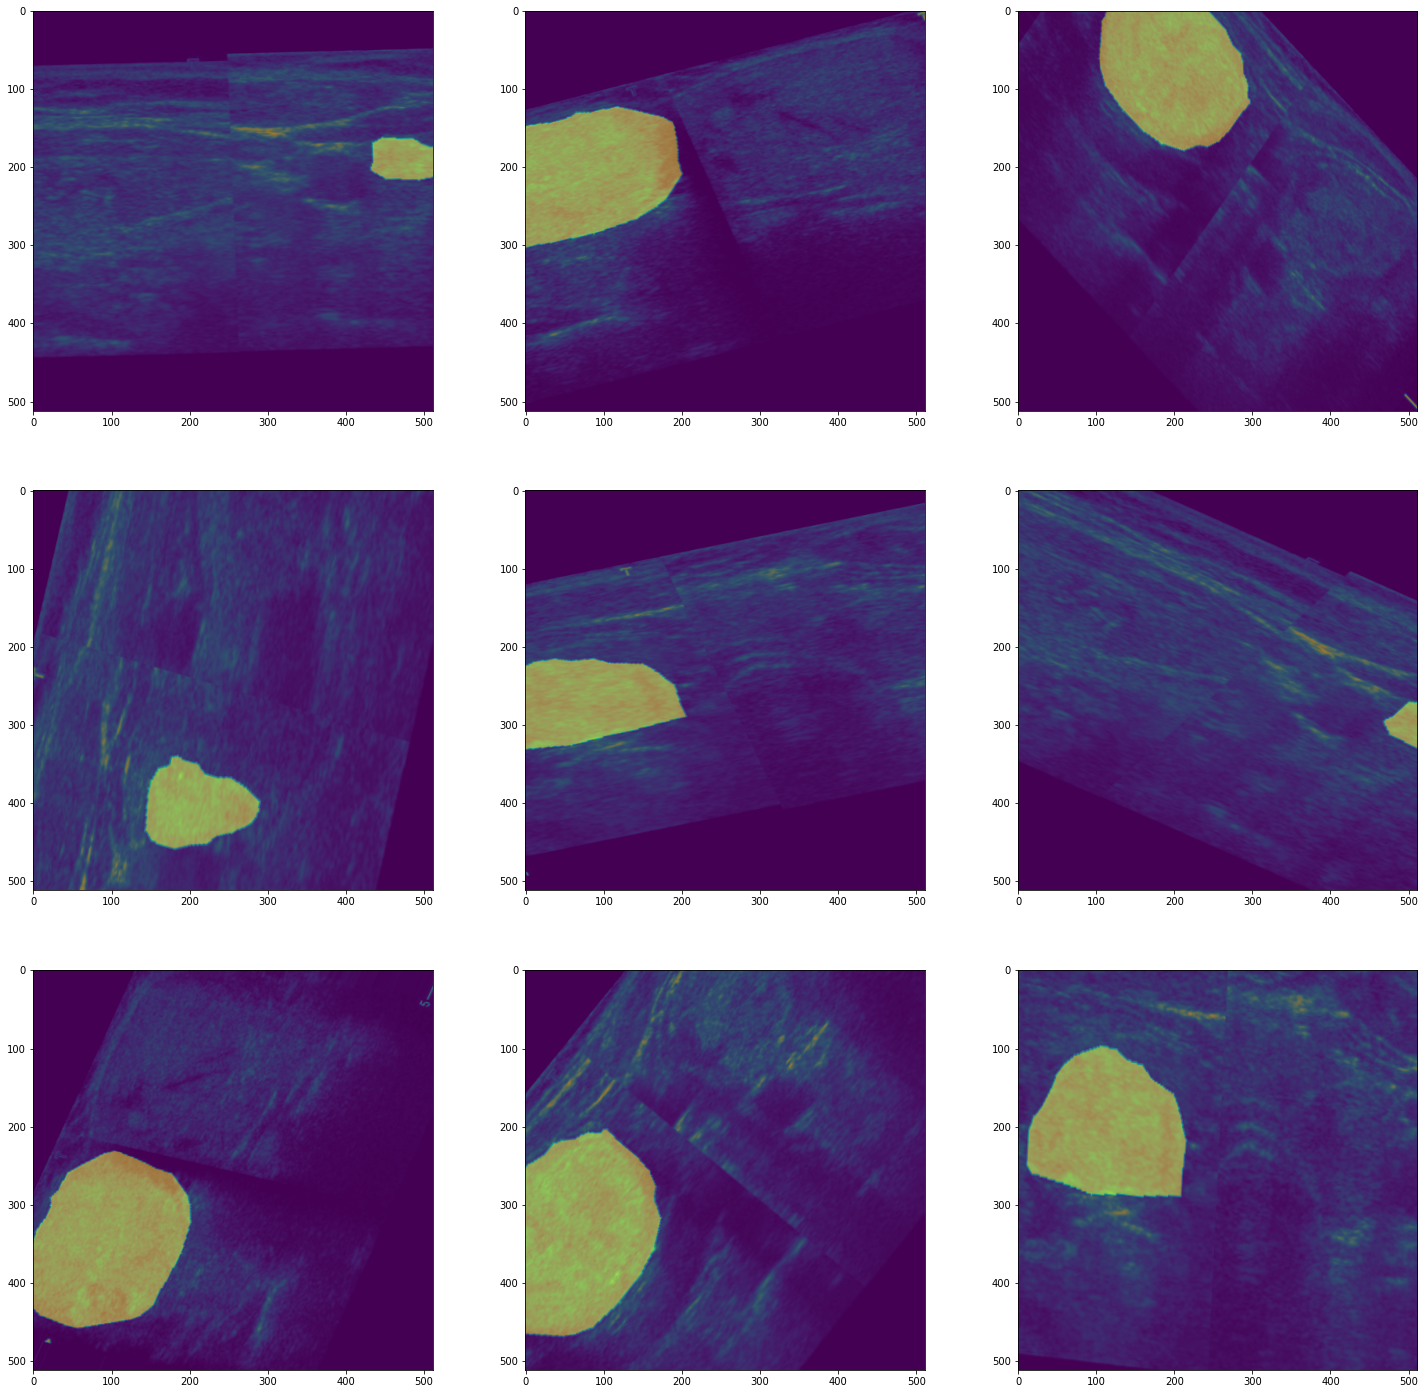

In [80]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90, zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(stacked, batch_size=1)

plt.figure(figsize=(25,25))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    stacked = batch[0].astype('uint8')
    image, mask = tf.unstack(stacked, axis=2)
    
    # plot raw pixel data
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
# show the figure
plt.show()

In [10]:
images, masks = gen.__getitem__(0)

/tmp/ipykernel_451/715642631.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_images), np.array(output_masks)


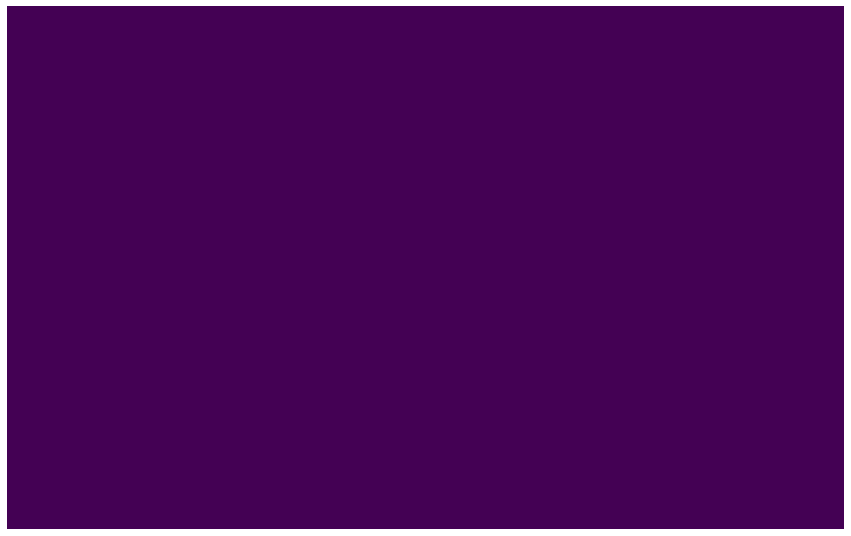

In [18]:
img = images[0]
msk = masks[0].squeeze()

zoomed = tf.keras.preprocessing.image.random_zoom(
            img,
            # 1.5,
            [0.99999, 0.99999],
            fill_mode='constant',
        )

plt.figure(figsize=(15,15))
plt.imshow(zoomed)
# plt.imshow(aug_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [122]:
new_img = np.expand_dims(image[0], axis=0)
new_img.shape

(1, 487, 1)

/tmp/ipykernel_323/3367652244.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_images), np.array(output_masks)


<class 'numpy.ndarray'>


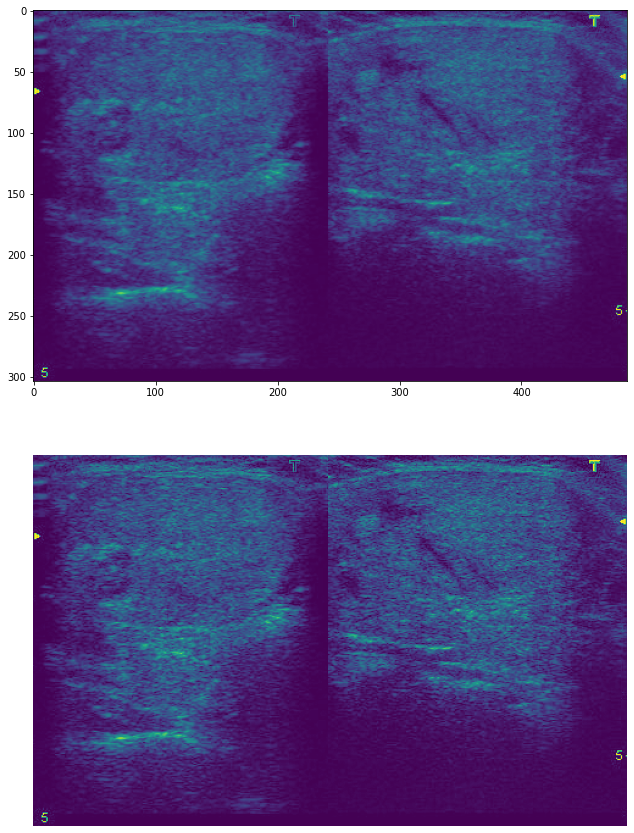

In [170]:
def sharpen(image, mask):
    # sharpened = tf.image.adjust_contrast(image, 2)
    sharpened = tfa.image.sharpness(image, 3)

    return sharpened, mask

show_mask = False

images, masks = gen.__getitem__(0)
image, mask = images[0], masks[0]
print(type(image))
aug_image, aug_mask = sharpen(image, mask)

# print(aug_image)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(image)
if show_mask:
    plt.imshow(mask, alpha=0.5)
plt.subplot(2,1,2)
plt.imshow(aug_image)
if show_mask:
    plt.imshow(aug_mask, alpha=0.5)
plt.axis('off')
plt.show()

# aug_image